<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Customer Segmentation with K-means Clustering and Data Preparation Piplelines
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Introduction</b></p>

<b style = 'font-size:20px;font-family:Arial;'>Leverage native Vantage processing for efficient and highly scalable data preparation, model training, and evaluation workflows</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>K-means clustering is one of the most popular <b>unsupervised</b> machine learning algorithms.  Essentially, the algorithm seeks to group similar data points together by minimizing the average ("means" in K-means) distance for all data points from each cluster's center (centroid).</p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
            <ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
                <li>Define the number of clusters (k)</li>
                <br>
                <li>The algorithm chooses random points as centroids</li>
                <br>
                <li>Each iteration attempts to optimize the centroid locations</li>
                <br>
                <li>Iterations end once the distances have stabilized or the max iteration count is reached</li>
            </ol>
        </td>
        <td><img src = 'images/K-means_convergence.gif' width = '250'></td>
    </tr>
</table>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>One limitation of this algorithm is that it only accepts numeric data as feature input (categorical clustering can be performed using K-modes algorithm).  Typically, data engineers or data scientists will perform multiple <b>serial</b> steps to prepare a numeric-only data set that can be passed to the K-means algorithm.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Vantage provides native "Fit and Transform" functions to assist in data preparation and transformation at scale.  To aid in efficiency and operationalization, Vantage provides a bulk <b>Column Transformer</b> function which can take multiple transformation directives at the same time, and act on the whole data set at once.  This allows for both process and code simplification, allowing more streamlined and robust operational deployment.</p> 

<img src = 'Flow_Diagram_KMeans.png' width = 100%>


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The data for this demonstration is based on online purchase history data set, which can be found <a href = 'https://www.kaggle.com/code/hellbuoy/online-retail-k-means-hierarchical-clustering/data'>here</a>.  The goal is to segment the customers by purchase volume and value.  Steps are as follow:</p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
            <ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
                <li>Analyze the raw data, split a testing set</li>
                <br>
                <li>Engineer numeric features</li>
                <br>
                <li>Build the K-means model</li>
                <br>
                <li>Apply in-line transformation to the testing set</li>
                <br>
                <li>Make Predictions and evaluate model accuracy</li>
            </ol>
        </td>
        <td><img src = 'images/clustering_img.png' width = '250'></td>
    </tr>
</table>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>1. Connect to Vantage</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>You will be prompted to provide the password. Enter your password, press Enter, then use down arrow to go to next cell.</p>

In [1]:
%connect local, hidewarnings=true

Password: ········


Success: 'local' connection established and activated for user 'demo_user', with default database 'demo_user'


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Setup for execution of notebook. Begin running steps with Shift + Enter keys.</p>

In [2]:
SET query_band='DEMO=K-Means_Clustering_and_ML_model_SQL.ipynb;' UPDATE FOR SESSION;

Success: 1 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b>Getting Data for This Demo</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We have provided data for this demo on cloud storage. In this demo since we are using Temporal table we will be creating databases and tables in local storage and use them in the notebook. Please execute the procedure in the next cell.</p>

In [3]:
-- call get_data('DEMO_Retail_cloud');    -- takes about 4 minutes
call get_data('DEMO_Retail_local');     -- takes about 7 minutes

Success: 0 rows affected

Success: 0 rows affected

,Message
1,That ran for 0:00:41.66 with 20 statements and 0 errors.


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Optional step – if you want to see status of databases/tables created and space used.</p>

In [4]:
call space_report();  -- optional, takes about 10 seconds

Success: 0 rows affected

Success: 0 rows affected

,Space_Report
1,"You have: #databases=2 #tables=3 #views=11 You have used 61.2 MB of 27,890.4 MB available - 0.2% ... Space Usage OK"
2,
3,Database Name #tables #views Avail MB Used MB
4,"demo_user 0 8 27,813.5 MB 0.7 MB"
5,DEMO_Retail 0 3 0.0 MB 0.0 MB
6,DEMO_Retail_db 3 0 76.9 MB 60.5 MB


<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b> Access data in Vantage  </b> </p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>For this demo, data is already resident in Object Storage which we are accessing via ReadNOS, create a reference to the table, and sample the contents using the get_data procedure used above.  Data could just as easily reside in permanent tables, another RDBMS, or another Vantage system.</p>

In [5]:
SELECT TOP 5 * FROM DEMO_Retail.UK_Retail_Data;

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,562615,85123A,WHITE HANGING HEART T-LIGHT HOLDER,5,2011-08-08 12:20:00.000000,2.95,16458,United Kingdom
2,562615,20725,LUNCH BAG RED RETROSPOT,10,2011-08-08 12:20:00.000000,1.65,16458,United Kingdom
3,562615,21931,JUMBO STORAGE BAG SUKI,10,2011-08-08 12:20:00.000000,2.08,16458,United Kingdom
4,562615,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,2,2011-08-08 12:20:00.000000,2.95,16458,United Kingdom
5,562615,82581,TOILET METAL SIGN,9,2011-08-08 12:20:00.000000,0.55,16458,United Kingdom


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>2. Data Preparation</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Here, we will inspect the original data set, and perform various preparation tasks.</p>

<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Inspect the rows of the table</li>
    <li>Inspect the column metadata using <a href = 'https://docs.teradata.com/search/all?query=TD_ColumnSummary&content-lang=en-US'>TD_ColumnSummary</a></li>
    <li>Split off a testing data set to be used in evaluation</li>
    </ol>

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>2.1 View Column information</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><a href = 'https://docs.teradata.com/search/all?query=TD_ColumnSummary&content-lang=en-US'>TD_ColumnSummary</a> provides more details on column values and ranges</p>

In [6]:
SELECT * FROM TD_ColumnSummary(
    ON DEMO_Retail.UK_Retail_Data as inputtable
    USING
        targetcolumns('[0:7]')
) as dt;

,ColumnName,Datatype,NonNullCount,NullCount,BlankCount,ZeroCount,PositiveCount,NegativeCount,NullPercentage,NonNullPercentage
1,StockCode,VARCHAR(10) CHARACTER SET UNICODE,536641,0,0,,,,0,100
2,InvoiceDate,TIMESTAMP(6),536641,0,,,,,0,100
3,InvoiceNo,VARCHAR(10) CHARACTER SET UNICODE,536641,0,0,,,,0,100
4,Description,VARCHAR(40) CHARACTER SET UNICODE,536641,0,0,,,,0,100
5,Country,VARCHAR(25) CHARACTER SET UNICODE,536641,0,0,,,,0,100
6,CustomerID,FLOAT,401604,0,,0,401604,0,0,100
7,Quantity,BIGINT,536641,0,,0,526054,10587,0,100
8,UnitPrice,FLOAT,536641,0,,2510,534129,2,0,100


<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>2.2 Create a Testing data set</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From our sample data we are selecting some "Customer ID" values for testing later.</p>

In [7]:
REPLACE VIEW UK_Retail_Test_V as (
    SELECT * FROM DEMO_Retail.UK_Retail_Data 
    WHERE CustomerID IN ('17307', '12503', '18268', '12908', '13693')
);

Success: 0 rows affected

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>3. Feature Engineering</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Vantage provides many inDb feature engineering functions, in this section we will see how to prepare the data set for model training.  We will use standard SQL and various "Fit" functions to create input for the <a href = 'https://docs.teradata.com/search/all?query=TD_ColumnTransformer&content-lang=en-US'>TD_ColumnTransformer</a> function to take as input in order to execute a bulk transformation.</p>

<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Create a per-customer grouping of data</li>
    <li>Create Fit Tables
        <ul><li>Remove Outliers</li>
            <li>Impute Missing Values</li>
            <li>Create New Numeric Features</li>
            <li>Rescale the Data Set</li>
        </ul></li>
    <li>Call the final Transformation function</li>
    </ol>

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>3.1 Create a per-customer table</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Simple GROUP BY, exclude the testing IDs.<br> Note there are 4367 unique customers in this training set.</p>

In [8]:
REPLACE VIEW Customer_ID_Group_V AS (
    SELECT CustomerID,
        SUM(quantity) as TotalQuantity , 
        SUM(UnitPrice) as TotalPrice, 
        COUNT(DISTINCT(StockCode)) as TotalItems 
    FROM DEMO_Retail.UK_Retail_Data
    WHERE CustomerID NOT IN ('17307', '12503', '18268', '12908', '13693')
    GROUP BY CustomerID
);

Success: 0 rows affected

In [9]:
SELECT COUNT(*) FROM Customer_ID_Group_V;

,Count(*)
1,4368


<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>3.2 Create Fit Tables</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Vantage <a href = 'https://docs.teradata.com/search/all?query=Feature+Engineering+Transform+Functions&content-lang=en-US'>Feature Engineering Transform Functions</a> Use a "Fit and Transform" approach to make processing more modular and efficient.  "Fit tables" can be used as input to either individual Transform functions, or passed to a single <a href = 'https://docs.teradata.com/search/all?query=TD_ColumnTransformer&content-lang=en-US'>TD_ColumnTransformer</a> function.</p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Fit outlier removal using <a href = 'https://docs.teradata.com/search/all?query=TD_OutlierFilterFit&content-lang=en-US'>TD_OutlierFilterFit</a></li>
    <li>Fit a simple imputer to replace missing values using <a href = 'https://docs.teradata.com/search/all?query=TD_SimpleImputeFit&content-lang=en-US'>TD_SimpleImputeFit</a></li>
    <li>Fit column calculations to create new features using <a href = 'https://docs.teradata.com/search/all?query=TD_NonLinearCombineFit&content-lang=en-US'>TD_NonLinearCombineFit</a></li>
    <li>Call <a href = 'https://docs.teradata.com/search/all?query=TD_ColumnTransformer&content-lang=en-US'>TD_ColumnTransformer</a> to execute the transformations (to allow for Scaling)</li>
    <li>Rescale the data using <a href = 'https://docs.teradata.com/search/all?query=TD_ScaleFit&content-lang=en-US'>TD_ScaleFit/Transform</a></li>
            </ul></td>
        <td><img src = 'images/fit_transform.png' width = '300'></td>
    </tr>
    </table>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>TD_OutlierFilterFit</b> function calculates the lower_percentile, upper_percentile, count of rows and median for the specified input table columns. The calculated values for each column help the
    <b>TD_OutlierFilterTransform</b> function detect outliers in the input table.

In [10]:
-- Remove Outliers
-- Trim below 3rd, and above 97th percentile

CREATE MULTISET VOLATILE TABLE outlierFit_CS as (
    SELECT * from TD_OutlierFilterFit(
        ON Customer_ID_Group_V as inputTable
        USING
        TargetColumns('TotalQuantity','TotalPrice')
        LowerPercentile(0.03)
        UpperPercentile(0.97)
        OutlierMethod('Percentile')
        PercentileMethod('PercentileCont')
        ReplacementValue('Median')
    )as dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>TD_SimpleImputeFit </b>will output a table with the values that will be used to substitute the missing values<br>
    <b>TD_SimpleImputeTransform</b> will return the input data set with the missing values filled in.

In [11]:
-- Impute Missing Values
-- Replace any missing CustomerID with a specific value

CREATE MULTISET VOLATILE TABLE ImputeFit_CS AS (
    SELECT * FROM TD_SimpleImputeFit(
        ON Customer_ID_Group_V AS InputTable
        USING
        ColsForLiterals('CustomerID')
        Literals('19000')                                        
    ) AS dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>TD_NonLinearCombineFit</b> function returns the target columns and a specified formula which uses the non-linear combination of existing features.


In [12]:
-- Create a new column by multiplying quantity and price

SELECT * FROM TD_NonLinearCombineFit (
    ON Customer_ID_Group_V as InputTable
    OUT VOLATILE TABLE OutputTable (NonLinearCombineFit_CS_TotalSales)
    USING
        TargetColumns ('TotalQuantity','TotalPrice')
        Formula ('Y = X1*X0')
        ResultColumn ('TotalSales')
) AS dt;

Success: 0 rows affected

,TotalSales,TotalQuantity,TotalPrice
1,Y = X1*X0,,


In [13]:
-- Create another new column by diving the total sales by the number of unique items

SELECT * FROM TD_NonLinearCombineFit (
   ON Customer_ID_Group_V AS InputTable
   OUT VOLATILE TABLE OutputTable (NonLinearCombineFit_CS_SalesPerItem)
   USING
   TargetColumns ('TotalQuantity','TotalPrice','TotalItems')
   Formula ('Y = (X0*X1)/X2')
   ResultColumn ('SalesPerItem')
) AS dt;

Success: 0 rows affected

,SalesPerItem,TotalQuantity,TotalPrice,TotalItems
1,Y = (X0*X1)/X2,,,


<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>The TD_ColumnTransformer</b> function transforms the entire dataset in a single operation. You only need to provide the FIT tables to the function, and the function runs all transformations that you require in a
single operation. Running all the it table transformations together in one-go gives approx. 30% performance improvement over running each transformation sequentially.</p>

In [14]:
-- Execute ColumnTransformer to build the data set

CREATE MULTISET VOLATILE TABLE Transformed_Customer_ID_Group_VT AS (
    SELECT * from TD_ColumnTransformer(
        ON Customer_ID_Group_V AS InputTable
        
        ON OutlierFit_CS AS OutlierFilterFitTable DIMENSION
        ON ImputeFit_CS AS SimpleImputeFitTable DIMENSION
        ON NonLinearCombineFit_CS_TotalSales AS NonLinearCombineFitTable DIMENSION
        ON NonLinearCombineFit_CS_SalesPerItem as NonLinearCombineFitTable DIMENSION
    ) AS dt
)WITH DATA 
ON COMMIT PRESERVE ROWS;

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>TD_ScaleFit and TDScaleTransform </b>scales specified input
table columns i.e perform the specific scale methods like standard deviation, mean etc to the input columns </p> 

In [15]:
-- ScaleFit/Transform to rescale the data

SELECT * FROM TD_ScaleFit(
    ON Transformed_Customer_ID_Group_VT AS InputTable
    OUT VOLATILE TABLE OutputTable(ScaleFit_CS)
    USING
        TargetColumns('TotalQuantity','TotalItems','TotalPrice','TotalSales','SalesPerItem')
        ScaleMethod('range')
) AS dt;

Success: 0 rows affected

,TD_STATTYPE_SCLFIT,TotalQuantity,TotalItems,TotalPrice,TotalSales,SalesPerItem
1,min,24,1,6.819999999999999,206.70000000000002,12.75129228687416
2,max,4796,3695,1291.0499999999997,5.751069009999999e+06,555065.5000000001
3,sum,2.967656e+06,271301,937383.1639999992,1.0652000234370003e+09,1.7645179379158065e+07
4,count,4368,4368,4368,4368,4368
5,null,0,0,0,0,0
6,avg,679.4084249084249,62.111034798534796,214.60237271062252,243864.47423008247,4039.6472937632934
7,multiplier,1,1,1,1,1
8,intercept,0,0,0,0,0
9,location,24,1,6.819999999999999,206.70000000000002,12.75129228687416
10,scale,4772,3694,1284.2299999999998,5.750862309999999e+06,555052.7487077132


In [16]:
CREATE MULTISET VOLATILE TABLE Scaled_Transformed_Customer_ID_Group_VT AS (
    SELECT * FROM TD_ScaleTransform(
        ON Transformed_Customer_ID_Group_VT AS InputTable
        ON ScaleFit_CS as FitTable DIMENSION
        USING
            Accumulate('CustomerID')
    ) AS dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Let us look at the final values which we will now input to the model. </p> 

In [17]:
SELECT TOP 5 * FROM Scaled_Transformed_Customer_ID_Group_VT;

,CustomerID,TotalQuantity,TotalItems,TotalPrice,TotalSales,SalesPerItem
1,12649,0.11525565800502934,0.00785056848944234,0.06236421824751019,0.008638641880473055,0.00297291872088732
2,16669,0.1785414920368818,0.03789929615592853,0.3292167290905836,0.0654043932413329,0.004785698470778398
3,17394,0.04547359597652976,0.0008121277747698972,0.005411803181673066,0.0005411136334439558,0.0014717361721296419
4,13500,0.11756077116512992,0.01597184623714131,0.18021693933329705,0.02420078807277165,0.004162277753045963
5,12910,0.3495389773679799,0.012723335138061722,0.11691052225847395,0.04614431813791765,0.009945160564586202


<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>4. Build the K-means Model</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>As discussed above, the K-means algorithm takes a number of clusters "k", chooses a random starting point for each centroid, and iterates until a hard limit, or an optimum value is reached.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Finding an Ideal value for K</b></p>
<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The example below uses a value of 5 for the number of clusters to build the model against.  Typically, data scientists will build the model using various values for "k", and plot the "WCSS" (Within Cluster Sum-of-Squares) value on a series of each value chosen for k.  The "elbow" point (where the slope changes) is usually a good value for k.  <a href = 'https://docs.teradata.com/search/all?query=TD_KMeans&content-lang=en-US'>TD_KMeans</a> function will return this value as "TotalWithinSS : ###" as a row in the "td_modelinfo_kmeans" column.</p></td>
        <td><img src = 'images/WCSS_elbow.png' width = '300'></td>
    </tr>
    </table>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Other Function Parameters Include (but are not limited to)</b></p>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Input Table</li>
    <li>StopThreshold - The algorithm converges if the distance between the centroids from the previous iteration and the current iteration is less than the specified value.</li>
    <li>MaxIterNum</li>Specify the maximum number of iterations for the K-means algorithm. The algorithm stops after performing the specified number of iterations even if the convergence criterion is not met.
    </ul>

In [18]:
SELECT TOP 5 * from TD_KMeans (
    ON Scaled_Transformed_Customer_ID_Group_VT as InputTable
    OUT TABLE ModelTable(KMeans_Model)
    USING
        IdColumn('CustomerID')
        TargetColumns('TotalQuantity','TotalPrice','TotalItems','TotalSales','SalesPerItem')
        StopThreshold(0.0395)
        NumClusters(5)
        -- Seed(0)
        MaxIterNum(500)
        -- OutputClusterAssignment('true')
) AS dt;

Success: 0 rows affected

,td_clusterid_kmeans,TotalQuantity,TotalPrice,TotalItems,TotalSales,SalesPerItem,td_size_kmeans,td_withinss_kmeans,CustomerID,td_modelinfo_kmeans
1,2,0.12628561091890003,0.19100850984262494,0.02011004506483512,0.02668859174163989,0.005460674735405416,1082,12.523016588563792,,
2,4,0.21000082641701012,0.5552928816993753,0.039701991047530444,0.1253395467319963,0.01230365678297573,355,14.728360537634728,,
3,3,0.6221212951619491,0.6599737406251817,0.04814112975997112,0.43297020725958785,0.03428119021793607,156,13.176755462437939,,
4,1,0.45603446637712425,0.19079591960062872,0.031991424585310235,0.09219292594627396,0.020208149676309368,397,19.28166549602284,,
5,0,0.04652366587544249,0.05223708483293819,0.00681133181214007,0.0031753005054262,0.003382253441965391,2378,7.538329818692205,,


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From the generated model we can see how many ids are there in each cluster, what is the size of each cluster, number of iterations it took for model to converge etc.
    

In [19]:
SELECT TOP 5 td_clusterid_kmeans, td_size_kmeans FROM KMeans_Model;

,td_clusterid_kmeans,td_size_kmeans
1,2,1082
2,4,355
3,3,156
4,1,397
5,0,2378


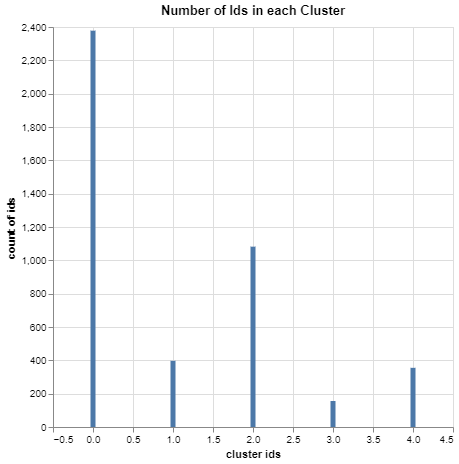

In [20]:
%chart x = td_clusterid_kmeans, y = td_size_kmeans, typex = q, typey = q,
labelx = "cluster ids", labely = "count of ids", type = bar,
title = "Number of Ids in each Cluster", height = 400, width = 400

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The above barchart shows the number of ids in each cluster where cluster_id is 0-4 generated by the TD_Kmeans function.<br>Let us now visualize how the clusters look like. We have used five columns to create clusters namely 'TotalQuantity','TotalPrice','TotalItems','TotalSales','SalesPerItem'.<br> For the visualization in 2d plane i.e with X and Y coordinates we will use two of these column values for our plots.

In [21]:
SELECT TOP 5 * FROM TD_KMeansPredict (
        ON Scaled_Transformed_Customer_ID_Group_VT AS InputTable
        ON KMeans_Model AS ModelTable DIMENSION
        USING
            OutputDistance('true')
            Accumulate('[1:5]')
) AS dt;

,CustomerID,td_clusterid_kmeans,td_distance_kmeans,TotalQuantity,TotalItems,TotalPrice,TotalSales,SalesPerItem
1,12957,3,0.20620033398660964,0.5253562447611064,0.0560368164591229,0.5329341317365269,0.30417984916074264,0.015130672657059908
2,13349,0,0.009225851369446442,0.04212070410729254,0.004060638873849486,0.04485177888695951,0.0024844621953746624,0.0016091352755077605
3,16434,2,0.08421952588823309,0.15423302598491198,0.023551705468327015,0.2679115111779043,0.04633428617072907,0.00543655713347243
4,16168,1,0.09186885618528345,0.3906119027661358,0.015159718462371413,0.25100643965644787,0.10803010514087587,0.019620266936850688
5,14090,0,0.05833357652574218,0.010058675607711651,0,0.09520490877802268,0.0015801838941958608,0.01672159759468308


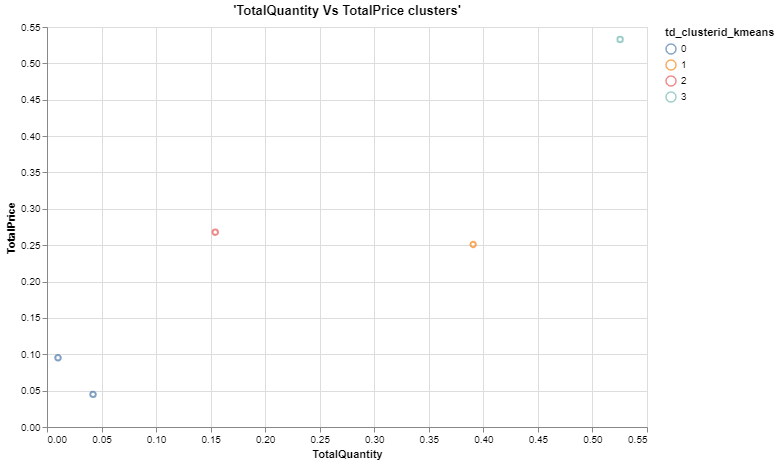

In [22]:
%chart x = TotalQuantity, y = TotalPrice, groupingcol = td_clusterid_kmeans, typegroupingcol = nominal,
mark = point, title = 'TotalQuantity Vs TotalPrice clusters', height = 400, width = 600

<p style = 'font-size:16px;font-family:Arial;color:#00233C'> In the above chart we have plotted TotalQuantity Vs TotalPrice to see how the clusters look like in the 2d plane where X axis is TotalQuantity and Y axis is TotalPrice. Note that this is only due to the limitation of visualization on being only in 2 dimensions where as the cluster creation is based on all 5 columns.

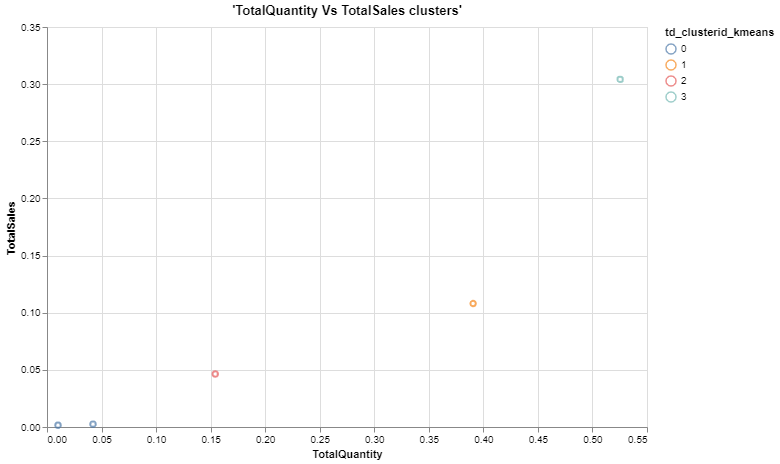

In [23]:
%chart x = TotalQuantity, y = TotalSales, groupingcol = td_clusterid_kmeans, typegroupingcol = nominal,
mark = point, title = 'TotalQuantity Vs TotalSales clusters', height = 400, width = 600

<p style = 'font-size:16px;font-family:Arial;color:#00233C'> In the above chart we have plotted TotalQuantity Vs TotalSales. See how the chart is different from the TotalQuantity Vs TotalPrice chart. You can change the values for x-axis and y-axis to see how the clusters with rest of the columns looks like.

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>5. Bulk Transformation</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Here, the Fit tables created above will be passed to a single <a href = 'https://docs.teradata.com/search/all?query=TD_ColumnTransformer&content-lang=en-US'>TD_ColumnTransformer</a> function.  This is similar to an operational approach, where a single query will prepare new or incoming data for immediate analysis.</p>

<img src = 'images/column_transformer.png' width = '300'>

In [24]:
SELECT TOP 5 * FROM UK_Retail_Test_V;

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,C542693,15036,ASSORTED COLOURS SILK FAN,-600,2011-01-31 12:36:00.000000,0.65,12908,United Kingdom
2,C541499,84819,DANISH ROSE ROUND SEWING BOX,-1,2011-01-18 15:23:00.000000,4.25,13693,United Kingdom
3,C541499,22325,MOBILE VINTAGE HEARTS,-3,2011-01-18 15:23:00.000000,4.95,13693,United Kingdom
4,C540271,M,Manual,-1,2011-06-01 11:51:00.000000,1126,12503,Spain
5,557092,15036,ASSORTED COLOURS SILK FAN,600,2011-06-16 15:39:00.000000,0.72,12908,United Kingdom


In [25]:
-- Steps broken up above can be put together into a single query

REPLACE VIEW Scaled_Transformed_Test_V AS (
    
SELECT * FROM TD_ColumnTransformer(
            -- Use our groupby inside the ON clause
            ON (SELECT CustomerID,
                    SUM(quantity) AS TotalQuantity , 
                    SUM(UnitPrice) AS TotalPrice, 
                    COUNT(DISTINCT(StockCode)) AS TotalItems
                FROM UK_Retail_Test_V
                GROUP BY CustomerID
                ) AS InputTable
            
            -- Pass each fit table from above as dimensions
            ON OutlierFit_CS AS OutlierFilterFitTable DIMENSION
            ON ImputeFit_CS AS SimpleImputeFitTable DIMENSION
            ON NonLinearCombineFit_CS_TotalSales AS NonLinearCombineFitTable DIMENSION
            ON NonLinearCombineFit_CS_SalesPerItem AS NonLinearCombineFitTable DIMENSION
            ON ScaleFit_CS as ScaleFitTable DIMENSION
    ) AS dt
)

Success: 0 rows affected

In [26]:
SELECT TOP 5 * FROM Scaled_Transformed_Test_V;

,CustomerID,TotalQuantity,TotalPrice,TotalItems,TotalSales,SalesPerItem
1,18268,0.07145850796311819,0.01454568106959034,0,0.0015825105018033377,0.016745703411708848
2,12503,0.07145850796311819,0.8714794078942247,0,0.07142986179406546,0.7404291748208797
3,13693,0.07145850796311819,0.011898180232512868,0.0008121277747698972,0.0013667167767749948,0.0036102401301112215
4,12908,0.07145850796311819,0.09520490877802268,0.0002707092582566324,0.008156920209762426,0.04241986236899423
5,17307,0.07145850796311819,0.09520490877802268,0,0.008156920209762426,0.0848626978559787


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>6. Predict and Evaluate</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Finally, we run the model against new (in this case testing) data using <a href = 'https://docs.teradata.com/search/all?query=TD_KMeansPredict&content-lang=en-US'>TD_KMeansPredict</a>.  The preparation step has been completed in a single query above.  Additionally, we will use an evaluation function <a href = 'https://docs.teradata.com/search/all?query=TD_Silhouette&content-lang=en-US'>TD_Silhouette</a> to analyze how well the new cluster predictions match the original model.</p>

<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Call TD_KMeansPredict</li>
    <li>Inpect the results</li>
    <li>Call TD_Silhouette on the output</li>
    </ol>

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>6.1 Call the Prediction Function</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Pass the Input Data, Model Table, and other parameters including columns to accumulate.  Note here we create a new View to assist with Silhouette analysis of the prediction.</p>

In [27]:
REPLACE VIEW KMeans_Output_V AS (
    SELECT * FROM TD_KMeansPredict (
        ON Scaled_Transformed_Test_V AS InputTable
        ON KMeans_Model as ModelTable DIMENSION
        USING
            OutputDistance('true')
            Accumulate('[1:5]')
    ) AS dt
)

Success: 0 rows affected

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>6.2 Inspect the Results</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Simple SELECT on the output view will show us the results</p>

In [28]:
SELECT TOP 5 * FROM KMeans_Output_V;

,CustomerID,td_clusterid_kmeans,td_distance_kmeans,TotalQuantity,TotalPrice,TotalItems,TotalSales,SalesPerItem
1,18268,0,0.04764348102031992,0.07145850796311819,0.01454568106959034,0,0.0015825105018033377,0.016745703411708848
2,12503,4,0.808589615064995,0.07145850796311819,0.8714794078942247,0,0.07142986179406546,0.7404291748208797
3,13693,0,0.04783604265002541,0.07145850796311819,0.011898180232512868,0.0008121277747698972,0.0013667167767749948,0.0036102401301112215
4,12908,0,0.06371429536237327,0.07145850796311819,0.09520490877802268,0.0002707092582566324,0.008156920209762426,0.04241986236899423
5,17307,0,0.09580320371653504,0.07145850796311819,0.09520490877802268,0,0.008156920209762426,0.0848626978559787


<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>6.3 Evaluate the Prediction</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><a href = 'https://docs.teradata.com/search/all?query=TD_Silhouette&content-lang=en-US'>TD_Silhouette</a> is a native Vantage function that evaluates the similarity of an object to its cluster (cohesion) compared to other clusters (separation).  The silhouette scores and its definitions are as follows:</p>

<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>1: Data is appropriately clustered</li>
    <li>-1: Data is not appropriately clustered</li>
    <li>0: Datum is on the border of two natural clusters</li>
    </ul>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>See the documentation for a full listing of parameters and return values.</p>

In [29]:
SELECT * FROM TD_Silhouette(
    ON KMeans_Output_V AS inputTable
    USING
        IdColumn('CustomerID')
        ClusterIdColumn('td_clusterid_kmeans')
        TargetColumns('[3:7]')
        OutputType('SCORE')
) AS dt;

,silhouette_score
1,0.7435035095255595


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>7. Clean up</b></p>
<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Worktables</b></p>

In [30]:
DROP VIEW UK_Retail_Test_V;

Success: 14 rows affected

In [31]:
DROP VIEW Customer_ID_Group_V;

Success: 10 rows affected

In [32]:
DROP TABLE KMeans_Model;

Success: 23 rows affected

In [33]:
DROP VIEW Scaled_Transformed_Test_V;

Success: 12 rows affected

In [34]:
DROP VIEW KMeans_Output_V;

Success: 14 rows affected

<p style = 'font-size:20px;font-family:Arial;color:#00233C'> <b>Database and Tables </b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The following code will clean up tables and databases created above.</p>

In [35]:
call remove_data('DEMO_Retail');    -- takes about 5 seconds, optional if you want to use the data later

Success: 0 rows affected

Success: 0 rows affected

,Message
1,Removed objects related to DEMO_Retail. That ran for 0:00:02.49


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'> <b> 8. Conclusion </b> </p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In this notebook we have seen some of the Teradata Vantage Clearscape's new inDb functions and how we can create k clustering model from the transformed data.</p>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Reference Links:</b></p>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
        <li>Teradata Analytic Function Reference:
        <a href = 'https://docs.teradata.com/r/Teradata-VantageCloud-Lake/Analyzing-Your-Data/Analytics-Database-Analytic-Functions/Analytics-Database-Analytic-Functions-Overview'>
        https://docs.teradata.com/r/Teradata-VantageCloud-Lake/Analyzing-Your-Data/Analytics-Database-Analytic-Functions/Analytics-Database-Analytic-Functions-Overview</a></li>
  
</ul>

<footer style="padding-bottom:35px; background:#f9f9f9; border-bottom:3px solid #00233C">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
    <div style="float:right;">
        <div style="float:left; margin-top:14px">
            Copyright © Teradata Corporation - 2023. All Rights Reserved
        </div>
    </div>
</footer>